# Optimization of univariate functions

Consider the following function to optimize.
$$
f(x) = x^2 + x -2\sqrt{x}
$$

In [1]:
f(x) = x^2 + x - 2*sqrt(x)

f (generic function with 1 method)

I just created a very cool function!

We can rewrite this function as

In [2]:
g(x::Float64) = x*(x+1) - 2*sqrt(x)

g (generic function with 1 method)

In [3]:
g(x::Int) = 1+1

g (generic function with 2 methods)

In [4]:
g(1.0)

0.0

In [5]:
g(1)

2

In [6]:
methods(g)

# 2 methods for generic function "g":
[1] g(x::Int64) in Main at In[3]:1
[2] g(x::Float64) in Main at In[2]:1

In [12]:
using Plots

pyplot()

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273


Plots.PyPlotBackend()

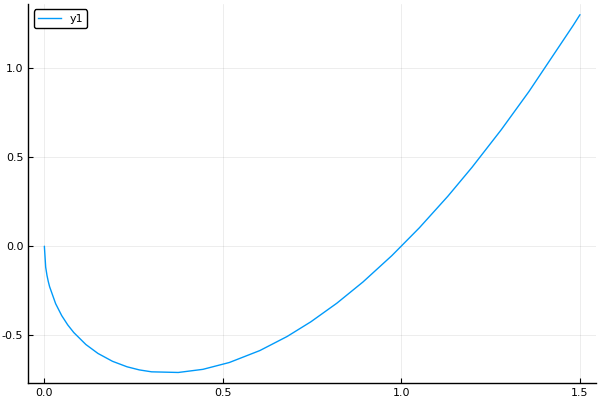

In [13]:
xmin = 0.0
xmax = 1.5
plot(g, xmin, xmax)

## Optimization with the Fibonacci method

Compute the Fibonacci numbers.

In [ ]:
N = 50
F = ones(N)

for i = 3:N
    F[i] = F[i-1] + F[i-2]
end

F

In [ ]:
F[length(F)]

In [ ]:
F[0]

Assume that we know that the solution is in [0,1].

In [ ]:
xmin = 0
xmax = 1.0

verbose = true

In [ ]:
function fibonacci(g::Function, xmin, xmax, verbose::Bool = false)
    k = 1
    i = 1
    d = xmax - xmin
    xG = xmin+(F[N-2]/F[N])*d
    xD = xmin+(F[N-1]/F[N])*d
    fG = g(xG)
    fD = g(xD)

    if (verbose)
        println("Iteration $k.\nxmin = $xmin, xmax = $xmax")
        println("xG = $xG, fG = $fG")
        println("xD = $xD, fD = $fD")
        println("d = $d")
    end

    while (k < N-2)
        k += 1
        i += 1
        if fG < fD
            xmax = xD
            d = xmax - xmin
            xD = xG
            fD = fG
            xG = xmin+(F[N-k-1]/F[N-k+1])*d
            fG = g(xG)
        elseif fG > fD
            xmin = xG
            d = xmax - xmin
            xG = xD
            fG = fD
            xD = xmin+(F[N-k]/F[N-k+1])*d
            fD = g(xD)
        elseif fG == fD
            k += 1
            if (k < N-2)
            xmin = xG
            xmax = xD
            d = xmax - xmin
            xG = xmin+(F[N-k-1]/F[N-k+1])*d
            xD = xmin+(F[N-k]/F[N-k+1])*d
            fG = g(xG)
            fD = g(xD)
            end
        end

        if verbose
            println("Iteration $i.\nxmin = $xmin, xmax = $xmax, $k = k")
            println("xG = $xG, fG = $fG")
            println("xD = $xD, fD = $fD")
            println("d = $d")
        end
    end
    
    return [xmin, xmax]
end

In [ ]:
methods(fibonacci)

In [ ]:
bounds = fibonacci(g, xmin, xmax, true)

In [ ]:
bounds[2]-bounds[1]

In [ ]:
function golden(f::Function, a, b, tol::Float64 = 1e-6)
    k = 1
    i = 1
    if (b < a)
        t = b
        b = a
        a = t
    end
    d = b - a
    
    # Golden ratio
    gr = (sqrt(5) + 1) / 2

    c = b - d / gr
    d = a + d / gr

    while (abs(c - d) > tol)
        if f(c) < f(d)
            b = d
        else
            a = c
        end

        c = b - (b - a) / gr
        d = a + (b - a) / gr
    end
    
    return a, b, (b + a) / 2
end

In [ ]:
golden(g, 0.0, 1.0)

In [ ]:
golden(g, 0.0, 1.0, 1e-8)

## Library Optim in Julia

Some optimization routines are directly available in Julia, and can be obtained with the command

In [ ]:
using Pkg
Pkg.add("Optim")

using Optim

The basic routine is optimize, taking as first argument the function to minimize, and for univariate functions, second and third arguments the initial lower and upper bound of the search interval.

### Golden section

The Golden Section search method is an extension of the Fibonacci approach, where $N$ is not specified, and is taken as $N \rightarrow \infty$. We specify it as the fourth argument.

In [ ]:
result = optimize(g, 0, 1, GoldenSection())

In [ ]:
Optim.minimizer(result)

In [ ]:
bounds

## Methods using derivatives

The derivate of $f$ is
$$
f'(x) = 2x+1-\frac{1}{\sqrt{x}}
$$
which can be translated in Julia as

In [3]:
df(x) = 2x+1-1.0/sqrt(x)

df (generic function with 1 method)

Set $f'(x) = 0$, i.e
$$
\frac{1}{\sqrt{x}} = 2x+1
$$
or
$$
\frac{1}{x} = 4x^2 + 4x + 1
$$
We therefore have to look for the roots of polynomial
$$
4x^3 + 4x^2 + x - 1 = 0.
$$
Not easy! We will use the roots finding library.

In [14]:
#  Pkg.add("Roots")
using Roots

In [ ]:
h(x) = x*(4x*(x+1)+1)-1

The function fzeros aim to find all the roots of a polynomial, but it is quite slow. We will just look for one zero of the function, in the interval $[0,1]$.

In [ ]:
?fzero

In [ ]:
fzero(h, 0, 1)

In [ ]:
fzeros(h, 0, 1)

### Bisection method

We can do it explicitely by coding our bisection function.

In [ ]:
function bisection(f::Function, a::Float64, b::Float64, δ::Float64 = 1e-8)

    k = 1
    if (a > b)
        c = a
        a = b
        b = c
    end

    fa = f(a)
    fb = f(b)
    if fa == 0
        return k, fa, a, a
    elseif fb == 0
        return k, fb, b, b
    end

    if fa*fb > 0
        println("The function must be of opposite signs at the bounds")
        return
    end

    d = b-a
    c = a+d/2
    fc = f(c)

    while (d > δ)
        if (verbose)
            println("$k. a = $a, b = $b, d = $d, c = $c, fc = $fc")
        end
        k += 1
        if (fc == 0)
            a = b = c
            break
        elseif (fc*fa < 0)
            b = c
            fb = fc
        else
            a = c
            fa = fc
        end
        d = b-a
        c = a+d/2
        fc = f(c)
    end            

    return k, fc, a, b
end

In [ ]:
methods(bisection)

In [ ]:
X = bisection(df, 0.0, 1.0)

In [ ]:
X = bisection(df, 0.0, 1.0, 1e-11)

In [ ]:
df(1.0)

In [ ]:
df(2.0)

In [ ]:
X = bisection(df, 1.0, 2.0, 1e-11)

In [ ]:
X

### Newton method

The second derivate of $f$ is
$$
f''(x) = 2+\frac{1}{2}x^{-\frac{3}{2}}.
$$

In [2]:
function d2f(x::Float64)
    return 2+x^(-3/2)/2
end

d2f (generic function with 1 method)

A basic implementation of the Newton approach follows.

In [4]:
function Newton(f::Function, df::Function, d2f:: Function, xstart::Float64, δ::Float64 = 1e-8, nmax::Int64 = 100)
    k = 1
    x = xstart
    if (verbose)
        fx = f(x)
        println("$k. x = $x, f(x) = $fx")
    end
    dfx = df(x)
    while (abs(dfx) > δ && k <= nmax)
        k += 1
        dfx = df(x)
        x = x-dfx/d2f(x)
        if (verbose)
            fx = f(x)
            println("$k. x = $x, f(x) = $fx")
        end
    end
end

Newton (generic function with 3 methods)

In [5]:
verbose = true
Newton(f, df, d2f, 0.1)

1. x = 0.1, f(x) = -0.5224555320336759
2. x = 0.2101698321896462, f(x) = -0.6625444777611704
3. x = 0.31601466047275417, f(x) = -0.7084236992061186
4. x = 0.3465158588881345, f(x) = -0.71072285402286
5. x = 0.3478083935817193, f(x) = -0.7107265760534248
6. x = 0.3478103847752347, f(x) = -0.7107265760622221
7. x = 0.347810384779931, f(x) = -0.7107265760622221


In [6]:
verbose = true
Newton(f, df, d2f, 100.0)

1. x = 100.0, f(x) = 10080.0


DomainError: DomainError with -0.42489377655586225:
sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).

In [10]:
x0 = 3.0
x1 = x0-df(x0)/d2f(x0)

verbose = true
Newton(f, df, d2f, 0.5)

1. x = 0.5, f(x) = -0.6642135623730951
2. x = 0.32842712474619007, f(x) = -0.7098797335674298
3. x = 0.34734380660605063, f(x) = -0.710726092865839
4. x = 0.3478101266311549, f(x) = -0.7107265760620742
5. x = 0.3478103847798521, f(x) = -0.7107265760622219
6. x = 0.34781038477993104, f(x) = -0.710726576062222


We see that we converge faster to the optimal solution.

## Numerical differentiation

It is not always easy to explicitely compute the derivative of a function. It is however possible to exploit the derivate definition in order to numerically approximate it. Let $f$ be derivable at $x$. The derivative is defined as
$$
    f'(x) = \lim_{\epsilon \rightarrow 0} \frac{f(x+\epsilon)-f(x)}{\epsilon}
$$
We can therefore approximate the derivative by choosing $\epsilon$ small enough and computing
$$
f'(x) \approx \frac{f(x+\epsilon)-f(x)}{\epsilon}
$$
for instance

In [11]:
ϵ = 1e-4
dgfd(x) = (g(x+ϵ)-g(x))/ϵ

dgfd (generic function with 1 method)

Applying the bisection method to that approximation, we obtain

In [17]:
fzero(dgfd, 0, 1)

0.3477603857669904

We cannot choose $\epsilon$ arbitrarily small, as illustrated below.

In [25]:
# fd: Finite difference
dffd(x, ϵ) = (f(x+ϵ)-f(x))/ϵ
x = 1.0
errfd(ϵ) = abs(df(x)-dffd(x, ϵ))
plot(errfd, 1e-14,1e-12)

UndefVarError: UndefVarError: plot not defined

In [26]:
ϵ = 1e-40
dgfd(x) = (g(x+ϵ)-g(x))/ϵ
fzero(dgfd,0,1)

1.0

The method can be refined using the central difference, defined as
$$
f'(x) \approx \frac{f(x+\epsilon)-f(x-\epsilon)}{2\epsilon}
$$

In [27]:
dfcd(x, ϵ=1e-6) = (f(x+ϵ)-f(x-ϵ))/(2*ϵ)

dfcd (generic function with 2 methods)

In [28]:
x = 1.0
errcd(ϵ) = abs(df(x)-dfcd(x, ϵ))
plot(errcd, 1e-18,0.1e-14)

UndefVarError: UndefVarError: plot not defined

The central difference provides smaller numerical errors, but at the expense of one additional function evaluation.

The numerical derivates are often expensive to compute, especially in multivariate problem, and we will look for automatic differentiation.

In [29]:
Newton(f, dfcd, d2f, 1.1)

1. x = 1.1, f(x) = 0.21238230365969724
2. x = 0.17678773862630892, f(x) = -0.6328810373010464
3. x = 0.2942185128994119, f(x) = -0.7040552143383558
4. x = 0.34392708747069356, f(x) = -0.7106930135038015
5. x = 0.34779235362665795, f(x) = -0.7107265753408357
6. x = 0.3478103843909892, f(x) = -0.7107265760622221
7. x = 0.34781038477877974, f(x) = -0.7107265760622219


In [30]:
dfhd(x, ϵ=1e-4) = (dfcd(x+ϵ)-dfcd(x))/ϵ

dfhd (generic function with 2 methods)

In [31]:
Newton(f, dfcd, dfhd, 1.1)

1. x = 1.1, f(x) = 0.21238230365969724
2. x = 0.17677563355014392, f(x) = -0.6328686318097565
3. x = 0.29424761704081137, f(x) = -0.7040626382540115
4. x = 0.343939312993119, f(x) = -0.7106932248221285
5. x = 0.3477929328575259, f(x) = -0.7107265753864391
6. x = 0.34781038647043694, f(x) = -0.7107265760622221
7. x = 0.34781038479398285, f(x) = -0.7107265760622219


In [34]:
using ForwardDiff

In [33]:
import Pkg
Pkg.add("ForwardDiff")

  Updating registry at `C:\Users\slash\.julia\registries\General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `C:\Users\slash\.julia\environments\v1.2\Project.toml`
  [f6369f11] + ForwardDiff v0.10.8
  Updating `C:\Users\slash\.julia\environments\v1.2\Manifest.toml`
 [no changes]


In [35]:
g2 = x -> ForwardDiff.derivative(f, x)

#3 (generic function with 1 method)

In [36]:
Newton(f, g2, dfhd, 1.1)

1. x = 1.1, f(x) = 0.21238230365969724
2. x = 0.17677563346369074, f(x) = -0.6328686317211533
3. x = 0.2942476245134814, f(x) = -0.70406264015959
4. x = 0.3439393183705949, f(x) = -0.7106932249149309
5. x = 0.34779293286432433, f(x) = -0.7107265753864397
6. x = 0.34781038649273033, f(x) = -0.7107265760622221
7. x = 0.34781038477972825, f(x) = -0.7107265760622221


In [37]:
errfd(x) = abs(df(x)-g2(x))
plot(errfd, 1,1.1)

UndefVarError: UndefVarError: plot not defined